In [431]:
import numpy                            as np
import pandas                           as pd
import matplotlib.pyplot                as plt
import seaborn                          as sns


from sklearn.metrics                    import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection            import KFold, train_test_split
from sklearn.compose                    import ColumnTransformer
from sklearn.pipeline                   import Pipeline
from sklearn.impute                     import SimpleImputer
from sklearn.preprocessing              import StandardScaler,OneHotEncoder,MinMaxScaler,RobustScaler,PolynomialFeatures
from category_encoders.target_encoder   import TargetEncoder
from category_encoders.cat_boost        import CatBoostEncoder
from lightgbm                           import LGBMRegressor
from xgboost                            import XGBRegressor
from catboost                           import CatBoostRegressor
from sklearn.linear_model               import LinearRegression, Lasso, Ridge
from sklearn.neighbors                  import KNeighborsRegressor
from sklearn.ensemble                   import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.tree                       import DecisionTreeRegressor
from scripts.modelos                    import Modelos
from scripts.funcoes                    import validacao, outlier

# Alterando algumas configurações de exibição do pandas
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)
sns.set_style("whitegrid")

In [432]:
car_train = pd.read_csv('treino.csv')
car_test = pd.read_csv('teste.csv')

________


# **Definições**

Antes de iniciarmos é necessário definirmos como os nossos modelos serão avaliados. Para esse projeto vamos utilizar as três métricas citadas a seguir:

1. **Mean absolute percentage error (MAPE);**
2. **Mean absolute error (MAE);**
3. **Root mean squared error (RMSE);**

A nossa principal métrica sera o MAPE e tomaremos como erro aceitável até no máximo 20\%, entretanto o desejável são erros menores que 15\%.

___

# **Baseline**

Inicialmente treinaremos vários modelos de regressão com o mínimo de tratamento possível da base de treino, o objetivo desse passo é a elaboração de uma baseline para referência.

Antes de iniciarmos vamos remover as variáveis modelo e ano.

* Modelos novos são lançados a cada ano, portanto, qualquer modelo que não esteja nos modelos de treinamento trará problema no momento da predição. Uma possível abordagem seria criar uma classe genérica onde qualquer modelo desconhecido seria configurado nessa classe genérica. Como esse projeto é apenas um breve projeto de portfólio, iremos remover essa feature, porém, podemos testar novas abordagens futuramente.


* Da análise dos dados observamos que as features ano_produção e idade tem o mesmo valor de coeficiente de pearson em módulo. Além disso observamos que utilizar a variável idade é muito mais interessante, pois muito dificilmente vamos ver por ai carros com mais de 70 anos de idade, dessa forma os valores da variável idade quase sempre estarão dentro do intervalo de idades utilizado no treinamento do modelo. Isso não acontece com o ano_produção, no nosso caso o ano_produção está limitado até 2019 e conforme o tempo for passando o ano de produção receberá valores acima de 2019, portanto, esses valores estarão fora do intervalo de treinamento. Por esse motivo vamos manter a variável idade e remover a variável ano_produção.


In [433]:
car_train = car_train.drop(columns=['modelo','ano_producao'])
car_test = car_test.drop(columns=['modelo','ano_producao'])

car_train['transmissao'] = np.where(car_train['transmissao']== 'automatic',True,False).astype('bool')
car_test['transmissao'] = np.where(car_test['transmissao']== 'automatic',True,False).astype('bool')

In [434]:
X_train = car_train.drop(columns=['preco'])
y_train = car_train['preco']

X_test = car_test.drop(columns=['preco'])
y_test = car_test['preco']

In [435]:
modelo= Modelos()

modelo.AddModel([('linear regression',LinearRegression()),
('Lasso',Lasso(alpha=0.5)),
('Ridge',Ridge(alpha=1)),
('Knn',KNeighborsRegressor()),
('Random Forest',RandomForestRegressor(random_state=42,n_jobs=-1)),
('lgbm',LGBMRegressor(random_state=42)),
('xgboost',XGBRegressor()),
('Catboost',CatBoostRegressor(random_seed=42,verbose=0))])

In [436]:
var_categoricos = X_train.select_dtypes('object').columns.tolist()

var_num = X_train.select_dtypes(exclude='object').columns.tolist()

var_all = X_train.columns.tolist()

In [437]:
cat_pipe = Pipeline([('encoder',TargetEncoder()),
                        ('inputer',SimpleImputer(strategy='most_frequent'))])

num_pipe = Pipeline([('impute',SimpleImputer(strategy='median'))])


preproc = ColumnTransformer([('categoricos',cat_pipe,var_categoricos),
                             ('numericos',num_pipe,var_num)])


model_pipeline = Pipeline([('Preprocessing',preproc)])

In [438]:
modelo.FitModels(X_train,y_train,model_pipeline)

-----linear regression-----
-----Lasso-----


/home/alexandre/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.328e+11, tolerance: 1.012e+08
  model = cd_fast.enet_coordinate_descent(


-----Ridge-----
-----Knn-----
-----Random Forest-----
-----lgbm-----
-----xgboost-----
-----Catboost-----


,mae,mape,rmse
linear regression,2117.196067,1.150264,1.144170e+07
Lasso,2117.211255,1.150967,1.144219e+07
Ridge,2117.275519,1.150454,1.144180e+07
Knn,2782.263791,1.380974,1.771836e+07
Random Forest,1145.469307,0.588369,3.944156e+06
lgbm,1116.859103,0.543951,3.474550e+06
xgboost,1102.896699,0.491381,3.453238e+06
Catboost,1055.913868,0.509217,3.153448e+06


Nosso melhor resultado sem basicamente nenhum tratamento dos dados foi de 49\% de erro médio percentual com o modelo xgboost.

Vamos continuar trabalhando em cima desses dados para que possamos alcançar melhores resultados, para isso vamos utilizar os resultados do xgboost para explorar o que podemos melhorar.

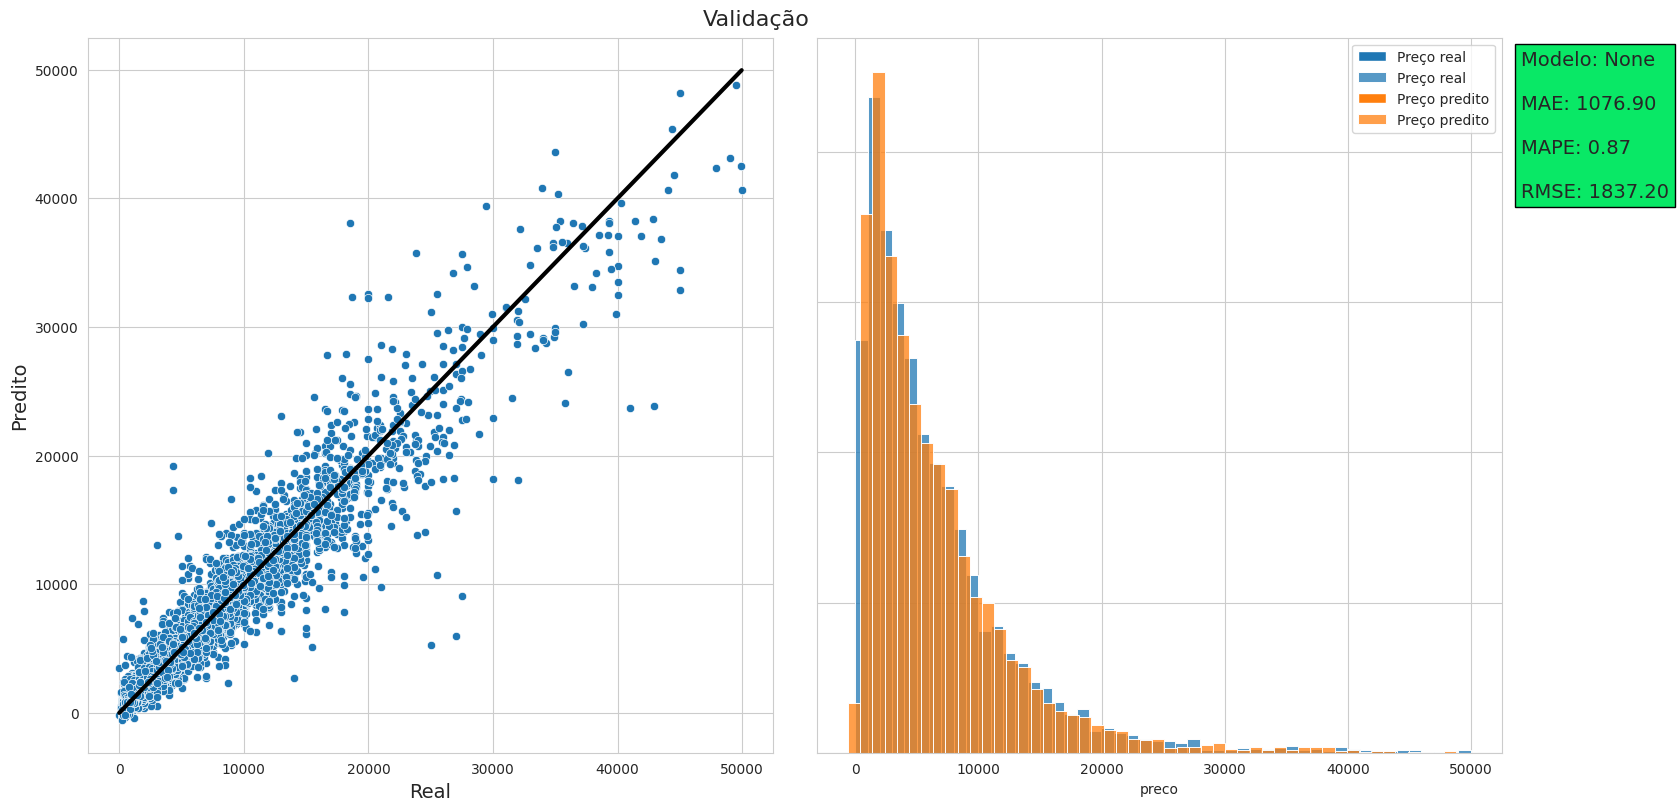

In [439]:
predito , real, _ = modelo.FitoneModel(X = X_train,y = y_train,pipe = model_pipeline,nome = 'xgboost')

validacao(real,predito)

**Observação importante:**  

* Utilizando o método FitModels, nós treinamos e validamos todos os modelos através de validação cruzada somente com os dados separados para treino.

* Utilizando o método FitoneModel, nós treinamos somente um modelo e os dados não são separados através de validação cruzada mas sim por HOLD OUT. 

Essa pequena diferença entre os dois métodos causa uma diferença nas métricas de avaliação como pode ser observado acima.

______

# **Modelando**

Já foi notado que o preço é uma variável assimétrica a direita, dessa forma sabemos que essa contém valores discrepantes. Uma estratégia seria identificar e remover esses valores, entretanto, antes de remover vamos aplicar o logaritmo na variável preço. Com essa transformação a variável preço se tornará mais simétrica e a variável idade e odômetro serão linearizadas, além disso, vamos evitar perder dados e consequentemente informação.

In [440]:
modelo.FitModels(X_train,y_train,model_pipeline,log_y=True)

-----linear regression-----
-----Lasso-----
-----Ridge-----
-----Knn-----
-----Random Forest-----
-----lgbm-----
-----xgboost-----
-----Catboost-----


,mae,mape,rmse
linear regression,1639.388521,0.532097,8.554181e+06
Lasso,2444.306772,0.705708,1.827347e+07
Ridge,1639.230041,0.532029,8.545970e+06
Knn,3294.440274,1.095103,2.837556e+07
Random Forest,1137.601512,0.457308,4.106964e+06
lgbm,1131.773202,0.471947,3.974656e+06
xgboost,1090.885679,0.458960,3.619817e+06
Catboost,1058.533009,0.453224,3.453285e+06


Nosso erro de 49\% caiu para +- 45\% apenas com a aplicação do logaritmo na variável alvo, além disso, observamos também que o erro dos modelos lineares caíram em uma quantidade razoável. 

* No notebook de análise exibimos com mais detalhes o que acontece com o preço e algumas outras variáveis depois de aplicada a transformação logarítmica.

## **Vamos adicionar um scaler**

Apesar de não ter muito sentido aplicar scaler em modelos baseados em árvore, vamos tentar mesmo assim e comparar os resultados.

In [441]:
cat_pipe = Pipeline([('encoder',TargetEncoder()),
                        ('inputer',SimpleImputer(strategy='most_frequent'))])

num_pipe = Pipeline([('impute',SimpleImputer(strategy='median')),
                     ('sccaler',StandardScaler())])


preproc = ColumnTransformer([('categoricos',cat_pipe,var_categoricos),
                             ('numericos',num_pipe,var_num)])


model_pipeline = Pipeline([('Preprocessing',preproc)])

modelo.FitModels(X_train,y_train,model_pipeline,log_y=True)

-----linear regression-----
-----Lasso-----
-----Ridge-----
-----Knn-----
-----Random Forest-----
-----lgbm-----
-----xgboost-----
-----Catboost-----


,mae,mape,rmse
linear regression,1639.388521,0.532097,8.554181e+06
Lasso,3405.387635,1.174648,3.440951e+07
Ridge,1639.262759,0.532043,8.548863e+06
Knn,1929.839203,0.670499,1.092147e+07
Random Forest,1137.740916,0.457698,4.108018e+06
lgbm,1133.800026,0.479537,3.985675e+06
xgboost,1090.970037,0.458995,3.619894e+06
Catboost,1058.533009,0.453224,3.453285e+06


Nos modelos baseados em arvores não houve melhoras significativas, entretanto, observamos que o modelo KNN apresentou melhora nos seus resultados. Isso ocorre pois esse modelo utiliza a distância entre as features para realizar as suas predições, portanto, ao aplicarmos o scaler nós atribuímos a cada feature valores numéricos em escalas similares, melhorando assim as predições do KNN.

## **Outliers**

Mesmo aplicando o logaritmo observamos alguns valores discrepantes, vamos tentar remove-los para ver se isso nos ajuda nas predições.

* Identificando os outliers com a variável preço transformada através da função outlier implementada no arquivo "funcoes.py". Essa função nos retorna os índices dos valores que ela classifica como outliers.

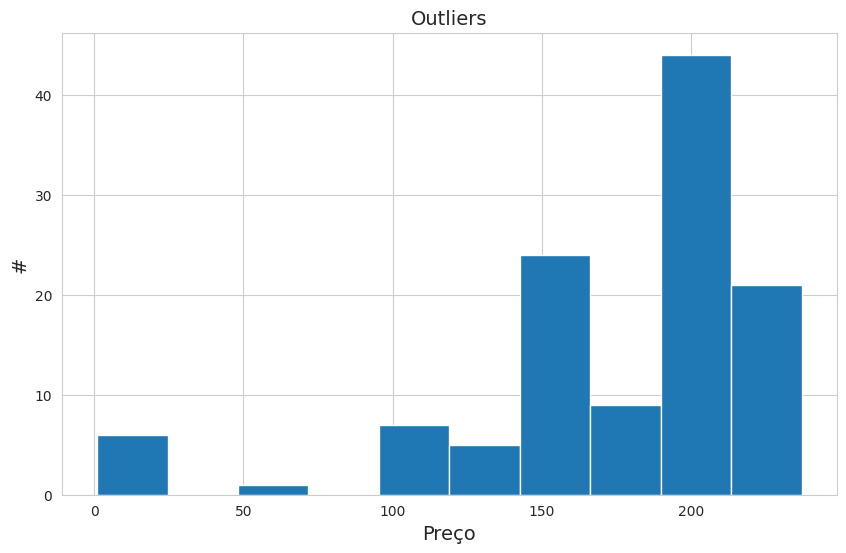

In [442]:
plt.figure(figsize=(10,6))
plt.title('Outliers',size=14)
plt.xlabel('Preço',size=14)
plt.ylabel("#",size=14)
idx = outlier(np.log(car_train['preco']))
car_train.loc[idx,'preco'].hist();

In [443]:
without_outlier = car_train.drop(index=idx)
without_outlier = without_outlier.reset_index(drop=True)

X_train = without_outlier.drop(columns=['preco'])
y_train = without_outlier['preco']

In [444]:
car_train.shape, without_outlier.shape

((30792, 30), (30675, 30))

In [445]:
cat_pipe = Pipeline([('encoder',TargetEncoder()),
                        ('inputer',SimpleImputer(strategy='most_frequent'))])

num_pipe = Pipeline([('impute',SimpleImputer(strategy='median')),
                     ('sccaler',StandardScaler())])


preproc = ColumnTransformer([('categoricos',cat_pipe,var_categoricos),
                             ('numericos',num_pipe,var_num)])


model_pipeline = Pipeline([('Preprocessing',preproc)])

modelo.FitModels(X_train,y_train,model_pipeline,log_y=True)

-----linear regression-----
-----Lasso-----
-----Ridge-----
-----Knn-----
-----Random Forest-----
-----lgbm-----
-----xgboost-----
-----Catboost-----


,mae,mape,rmse
linear regression,1638.755313,0.334349,8.384486e+06
Lasso,3432.131582,0.814623,3.471992e+07
Ridge,1638.607301,0.334312,8.379398e+06
Knn,1932.155078,0.397684,1.091975e+07
Random Forest,1142.332343,0.243666,4.133974e+06
lgbm,1125.978984,0.236632,3.917992e+06
xgboost,1092.112611,0.235257,3.606867e+06
Catboost,1050.589217,0.226551,3.402122e+06


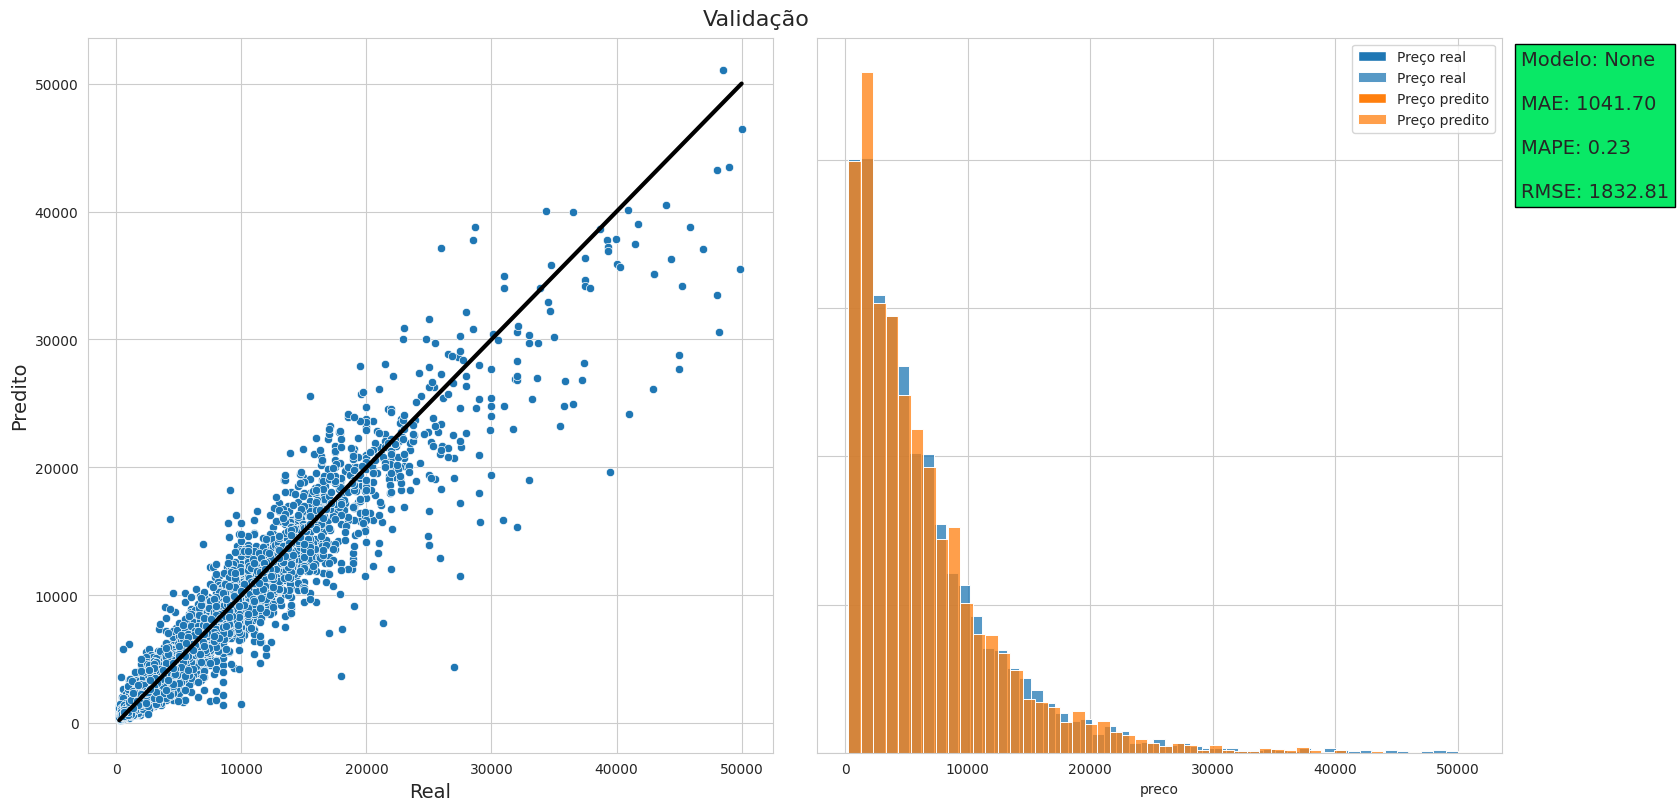

In [446]:
predito , real, avaliacao = modelo.FitoneModel(X = X_train,y = np.log(y_train),pipe = model_pipeline,nome = 'Catboost')

predito = np.exp(predito)

real = np.exp(real)

avaliacao['real'] = real
avaliacao['predito'] = predito
avaliacao['erro'] = np.abs(avaliacao['real'] - avaliacao['predito'])/avaliacao['real']

validacao(real,predito)

As nossas predições melhoraram muito depois que removemos esses outliers, o nosso MAPE caiu de 45\% para 22,6\%.  

**Uma observação:**

* Os valores outliers foram analisados com a variável preço transformada pelo logaritmo, com essa ação nós removemos poucos dados e diminuímos nosso erro quase que pela metade, e se tivéssemos analisado os outliers sem aplicar o logaritmo nós teríamos removido muitos mais dados. O valor se encontra aqui, perdemos pouca informação e melhoramos muito a qualidade das nossas predições.

*  Agora os valores das métricas obtidos pela validação cruzada e pelo Hold out estão mais coerentes.

In [447]:
car_train = without_outlier.copy()
X_train = car_train.drop(columns=['preco'])
y_train = car_train['preco']

Vamos analisar melhor alguns pontos cujo o erro é maior que 20\%.

OBS: Aqui estamos tomando o erro percentual da maneira que está definido a seguir: 

$E(\%) = \dfrac{|Real - Predito|}{Real}$

É interessante observar que a análise do erro percentual ponto a ponto tem de fato média igual a 23\%, como dado pela métrica MAPE. Além disso, olhar os quartis é muito mais informativo do que apenas visualizar a média.

É claro que mais da metade dos dados estão com erro menor que 18\% e 75\% dos dados tem erro até 27\%. 

Observamos também a distribuição assimétrica que explica o motivo da média estar $\pm$ 10 pontos percentuais acima da mediana.

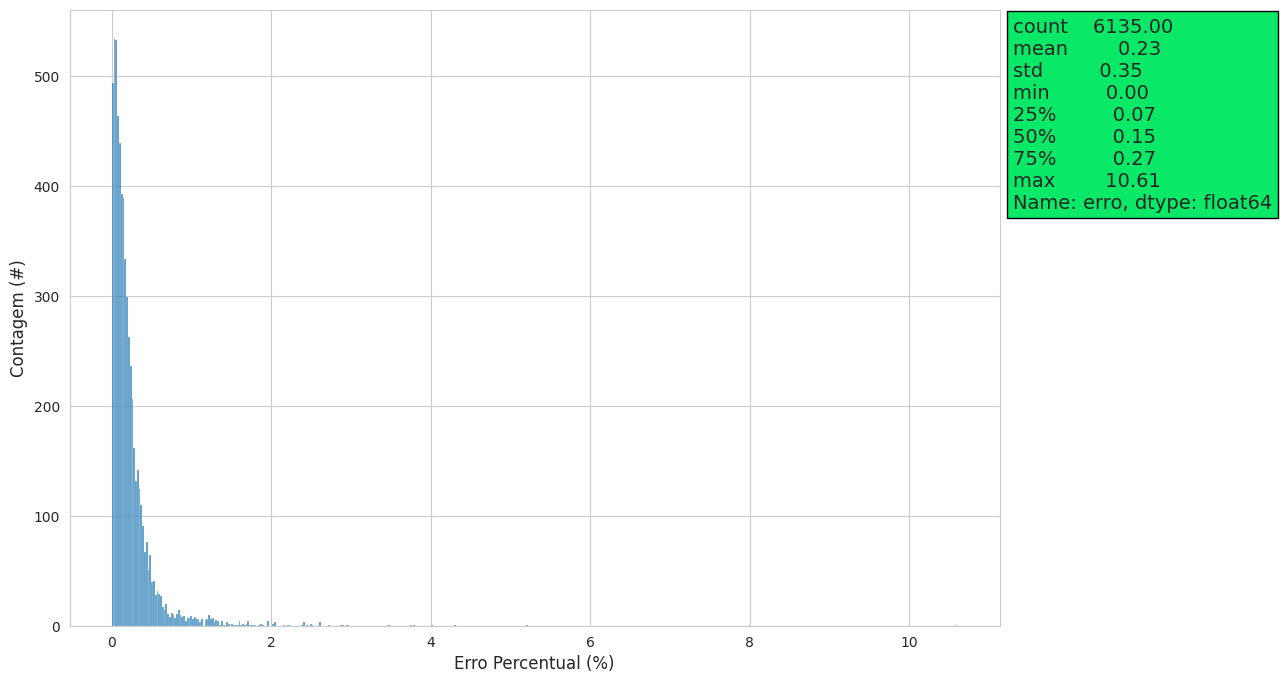

In [448]:
plt.figure(figsize=(12,8))
plt.ylabel("Contagem (#)",size=12)
plt.xlabel('Erro Percentual (%)',size=12)
sns.histplot(data=avaliacao,x='erro')

texto = f"{round(avaliacao['erro'].describe(),2)}"
plt.text(11.3,380,texto,size=14,bbox=dict(boxstyle='square',ec= (0,0,0), fc= (9/255, 232/255, 102/255)));

Ao remover o scaler nós observamos que não há nenhuma alteração no modelo Catboost como previmos antes um pouco mais acima.

In [449]:
cat_pipe = Pipeline([('encoder',TargetEncoder()),
                        ('inputer',SimpleImputer(strategy='most_frequent'))])

num_pipe = Pipeline([('impute',SimpleImputer(strategy='median'))])


preproc = ColumnTransformer([('categoricos',cat_pipe,var_categoricos),
                             ('numericos',num_pipe,var_num)])


model_pipeline = Pipeline([('Preprocessing',preproc)])


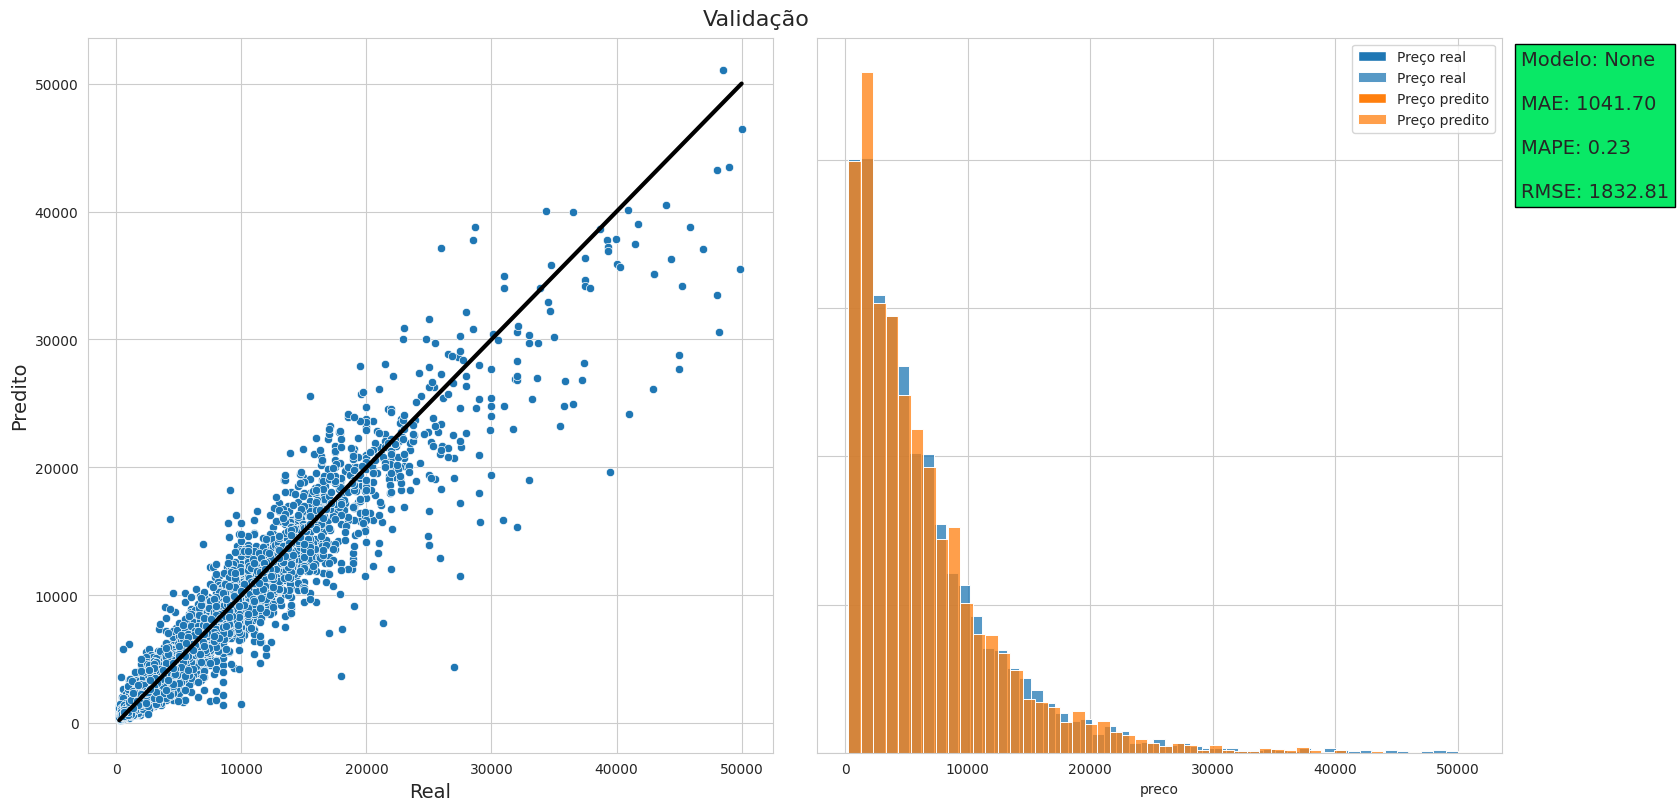

In [450]:
predito , real, avaliacao = modelo.FitoneModel(X = X_train,y = np.log(y_train),pipe = model_pipeline,nome = 'Catboost')

predito = np.exp(predito)

real = np.exp(real)

avaliacao['real'] = real
avaliacao['predito'] = predito
avaliacao['erro'] = np.abs(avaliacao['real'] - avaliacao['predito'])/avaliacao['real']

validacao(real,predito)

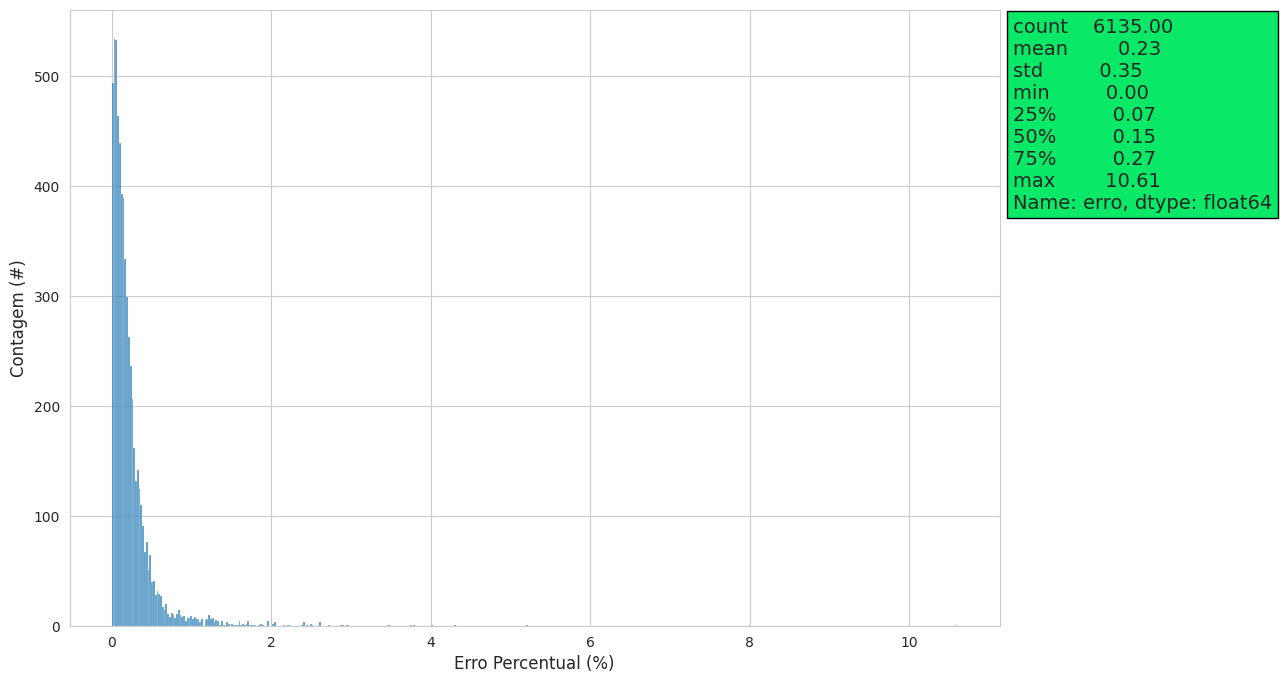

In [451]:
plt.figure(figsize=(12,8))
plt.ylabel("Contagem (#)",size=12)
plt.xlabel('Erro Percentual (%)',size=12)
sns.histplot(data=avaliacao,x='erro')

texto = f"{round(avaliacao['erro'].describe(),2)}"
plt.text(11.3,380,texto,size=14,bbox=dict(boxstyle='square',ec= (0,0,0), fc= (9/255, 232/255, 102/255)));

# **Validação**

Obtemos um modelo que julgamos interessante e agora é o momento ideal para realizarmos a validação utilizando o nosso conjunto de teste.

In [452]:
model_pipeline.steps.pop()
model_pipeline.steps.append(('modelo',modelo.models['Catboost']))
reg = model_pipeline

In [453]:
reg.fit(X_train,np.log(y_train))

predito = np.exp(reg.predict(X_test))


avaliacao = X_test.copy()

avaliacao['real'] = y_test.copy()
avaliacao['predito'] = predito
avaliacao['erro'] = np.abs(avaliacao['real'] - avaliacao['predito'])/avaliacao['real']

avaliacao_base = avaliacao.copy()
avaliacao_base['erro'].describe().to_frame()



,erro
count,7699.000000
mean,0.362636
std,8.379750
min,0.000017
25%,0.065631
50%,0.142995
75%,0.266340
max,589.541875


Ao comparar as estatísticas descritivas do erro percentual obtido agora na validação com as ultimas estatísticas obtidas no treinamento observamos que em média eles são diferentes, mas ao observar os quartis notamos que são basicamente idênticos e indica que o nosso modelo foi bem treinado e validado, além disso, na mediana os erros estão bem próximos. 

Agora vamos analisar as nossas predições para podermos entender melhor a nossa solução e sugerir modificações, além disso vamos buscar entender o motivo da média do treinamento estar diferente da média da validação.

# **Uma breve análise acerca dos resultados**

In [454]:
total_linhas = avaliacao.shape[0]
maior_100 = avaliacao.query('erro > 1')
print(f"Houve {maior_100.shape[0]} predições cujo o erro percentual foi maior que 100% e isso corresponde a {maior_100.shape[0]/total_linhas * 100:.2f}% do dataset de validação")

Houve 210 predições cujo o erro percentual foi maior que 100% e isso corresponde a 2.73% do dataset de validação


Através da estatística descritiva observamos veículos custando um dólar, vamos investigar isso melhor.

In [455]:
maior_100.describe().T

,count,mean,std,min,25%,50%,75%,max
odometro,210.0,258256.619048,156959.331649,11.000000,142500.000000,259500.000000,344288.250000,1000000.000000
capacidade_motor,210.0,1.931905,0.508757,0.800000,1.600000,1.900000,2.100000,5.400000
n_fotos,210.0,7.266667,4.839563,1.000000,4.000000,6.000000,9.000000,30.000000
atualizacoes,210.0,10.471429,26.081243,1.000000,1.000000,3.000000,9.750000,222.000000
dias_listado,210.0,70.157143,106.957082,0.000000,15.000000,47.500000,87.000000,1243.000000
idade,210.0,25.747619,8.701214,5.000000,22.000000,25.000000,28.000000,59.000000
qt_combustivel,210.0,1.042857,0.203019,1.000000,1.000000,1.000000,1.000000,2.000000
real,210.0,666.285714,531.485244,1.000000,333.487500,500.000000,800.000000,3200.000000
predito,210.0,1764.650445,1418.508454,420.110094,825.993579,1291.963697,2279.697434,10002.110312
erro,210.0,6.676445,50.439598,1.001651,1.200126,1.446354,2.122123,589.541875


Um caso interessante de se observar são nos erros excepcionalmente grandes e logo de cara entendemos o motivo dessas predições terem um erro enorme, trata-se que esses 2 registros logo abaixo tem o preço de um dólar, isso é, não se trata do preço verdadeiro do automóvel. Entretanto, observamos que ambos os veículos estão com algum defeito (emergency), logo pode ser que o vendedor desse carro esta sujeito a negociações e por isso colocou o preço do carro a um dólar apenas por simbolismo. 

Podemos concluir que esses carros são literalmente um ruido para o nosso modelo.

E muito provavelmente são esses erros muito grandes que estão causando a diferença observada entre a média do treino com a média do teste.


**Observação:**  

* Nosso objetivo aqui é analisar os nossos erros, entretanto, se esse modelo estivesse em produção, saberíamos dentro de uma faixa de erro qual seria o preço real desses dois veículos e isso serviria de base para podermos negociar a compra desses automóveis.

In [456]:
maior_100.query('erro > 10')[['fabricante','estado','real','predito','erro']]

,fabricante,estado,real,predito,erro
1664,Fiat,emergency,1.0,439.944625,438.944625
3064,Peugeot,emergency,1.0,590.541875,589.541875


Agora que identificamos um dos problemas, vamos analisar a parcela dos dados cujo o erro é maior do que 20\% e menor do que esses dois erros excepcionalmente grandes que determinamos na célula acima.

In [457]:
erros  =  avaliacao.query('erro > 0.2 and erro < 10')

print(f"Houve {erros.shape[0]} predições cujo o erro percentual está entre 20%-10000% e isso corresponde a {erros.shape[0]/total_linhas * 100:.2f}% do dataset de validação")

Houve 2774 predições cujo o erro percentual está entre 20%-10000% e isso corresponde a 36.03% do dataset de validação


In [458]:
erros.describe().T

,count,mean,std,min,25%,50%,75%,max
odometro,2774.0,268009.237563,144106.834878,0.000000,180000.000000,270000.000000,347000.000000,1000000.000000
capacidade_motor,2774.0,2.025739,0.642441,0.500000,1.600000,1.900000,2.200000,6.000000
n_fotos,2774.0,9.035328,6.095955,1.000000,5.000000,8.000000,11.000000,71.000000
atualizacoes,2774.0,14.953497,34.903551,1.000000,2.000000,4.000000,14.750000,699.000000
dias_listado,2774.0,80.831291,109.251215,0.000000,22.000000,59.000000,90.750000,1543.000000
idade,2774.0,19.276857,8.239766,0.000000,14.000000,20.000000,24.000000,59.000000
qt_combustivel,2774.0,1.043619,0.204283,1.000000,1.000000,1.000000,1.000000,2.000000
real,2774.0,4842.778295,6097.366801,94.850000,1300.000000,2800.000000,5839.885000,49999.000000
predito,2774.0,4595.134348,5162.173291,330.721545,1315.824902,2615.364478,5784.412482,39768.540767
erro,2774.0,0.476647,0.484219,0.200008,0.250092,0.327533,0.486043,6.352632


### **Vamos entender através do auxilio do gráfico de função acumulada algumas features númericas**

Hoje estamos em 2023 e um carro de 25 anos de idade foi lançado em 1998. Não me parece uma boa estratégia fazer negocio com carros tão antigos assim, obviamente que cada caso é um caso e essa é apenas a minha opinião. 

80% das predições com erro maior do que 20% é menor ou igual a 25.00 anos


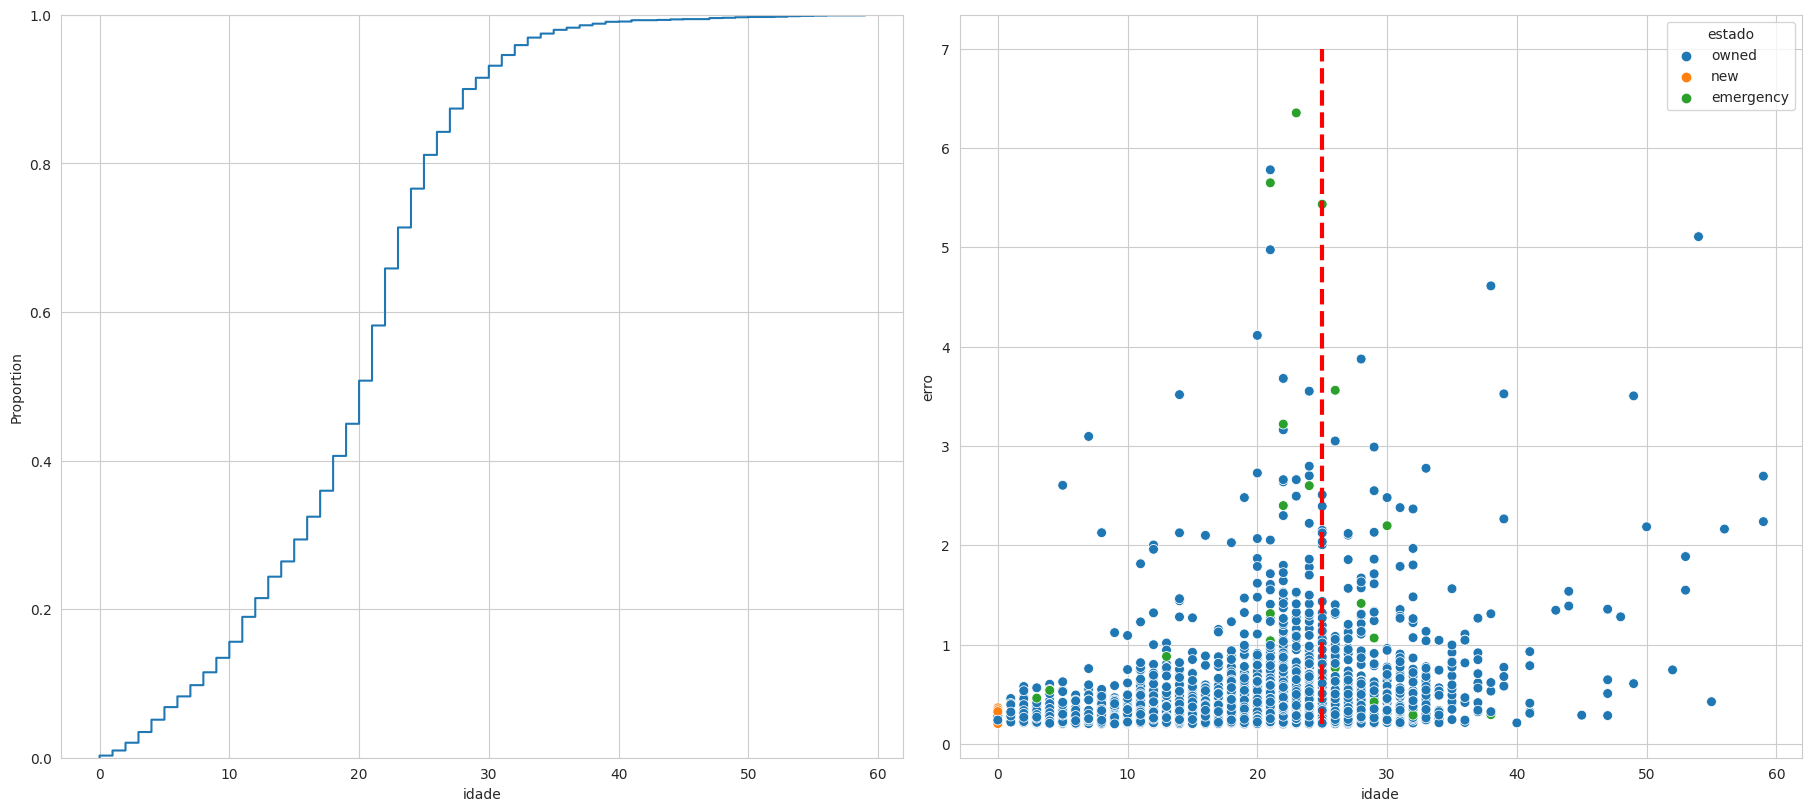

In [459]:
print(f"80% das predições com erro maior do que 20% é menor ou igual a {erros['idade'].quantile(0.8):.2f} anos")

fig , ax = plt.subplots(1,2,constrained_layout=True,figsize=(18,8))

sns.ecdfplot(data=erros, x='idade',ax=ax[0]);
sns.scatterplot(data=erros, x='idade',y='erro',ax=ax[1],hue='estado',s=50);

ax[1].vlines(25,0.2,7,linestyles='dashed',linewidth=3,color='red');

Da análise descritiva dos dados observamos que o preço de um automóvel diminui conforme a quilometragem do veículo aumenta, portanto, talvez devêssemos evitar quilometragens altas.

80% das predições tem a quilometragem menor igual que 360000.00Km


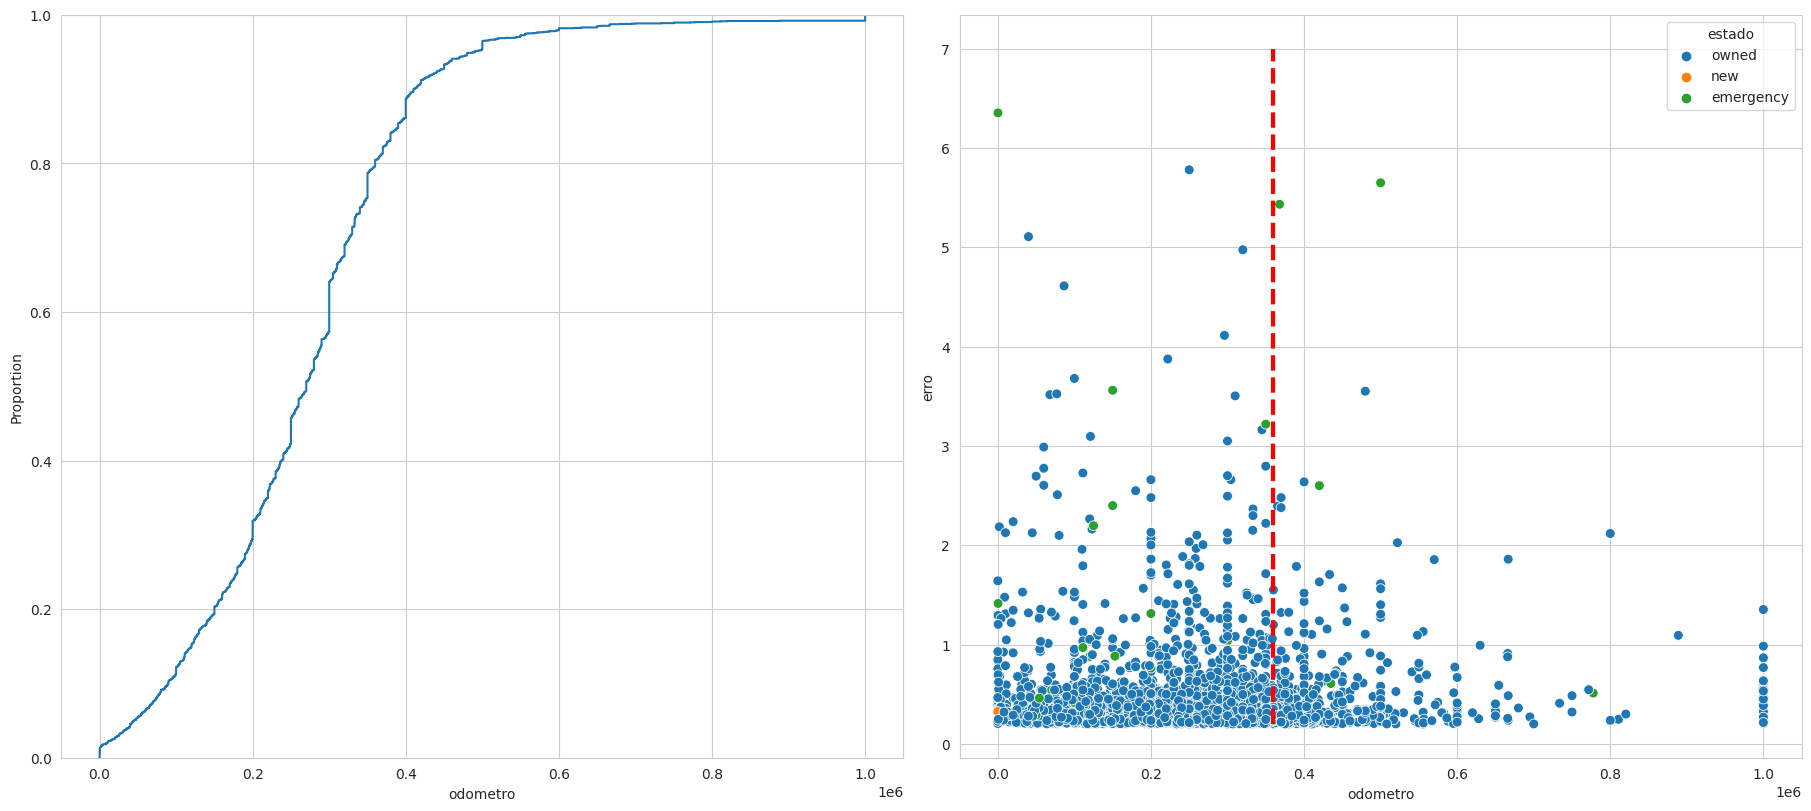

In [460]:
print(f"80% das predições tem a quilometragem menor igual que {erros['odometro'].quantile(0.8):.2f}Km")

fig , ax = plt.subplots(1,2,constrained_layout=True,figsize=(18,8))

sns.ecdfplot(data=erros, x='odometro',ax=ax[0]);
sns.scatterplot(data=erros, x='odometro',y='erro',ax=ax[1],hue='estado',s=50);

ax[1].vlines(360000,0.2,7,linestyles='dashed',linewidth=3,color='red');

É interessante observar que 80\% dos preços reais onde ocorre erros maiores que 20\% são menores que \$7200 dólares e isso confirma o fato de que os erros estão sendo cometidos nos menores preços, abordaremos essa questão futuramente nesse trabalho.  

80% das predições tem o preço menor igual que $7199.40 dolares


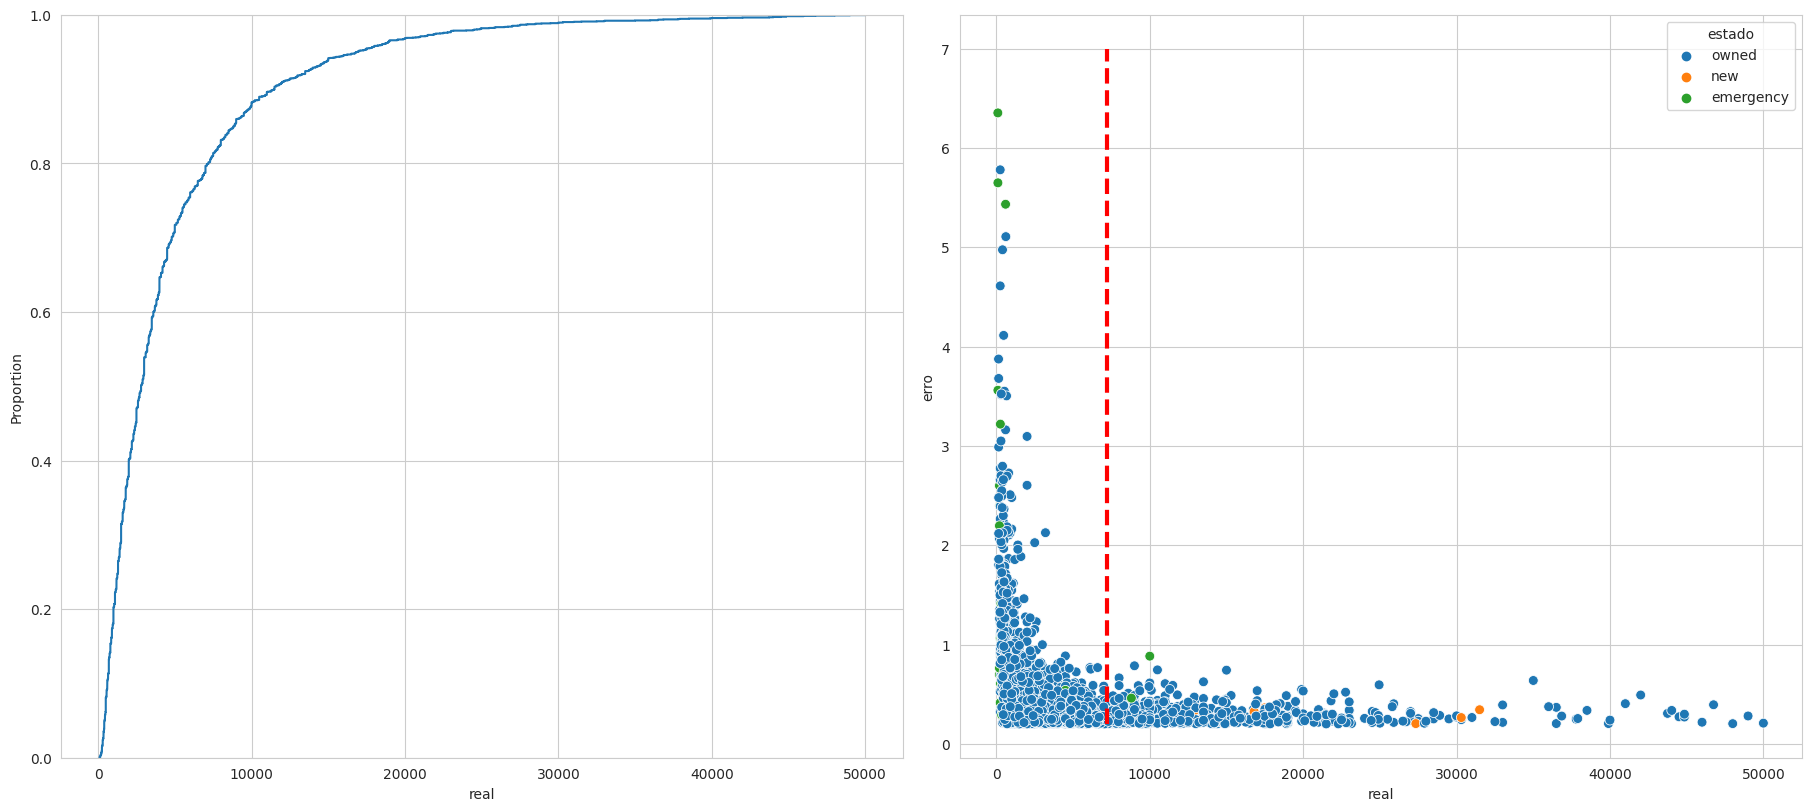

In [461]:
print(f"80% das predições tem o preço menor igual que ${erros['real'].quantile(0.8):.2f} dolares")

fig , ax = plt.subplots(1,2,constrained_layout=True,figsize=(18,8))

sns.ecdfplot(data=erros, x='real',ax=ax[0]);
sns.scatterplot(data=erros, x='real',y='erro',ax=ax[1],hue='estado',s=50);


ax[1].vlines(7199.40,0.2,7,linestyles='dashed',linewidth=3,color='red');

Na mediana o erros são maiores para veículos com algum defeito

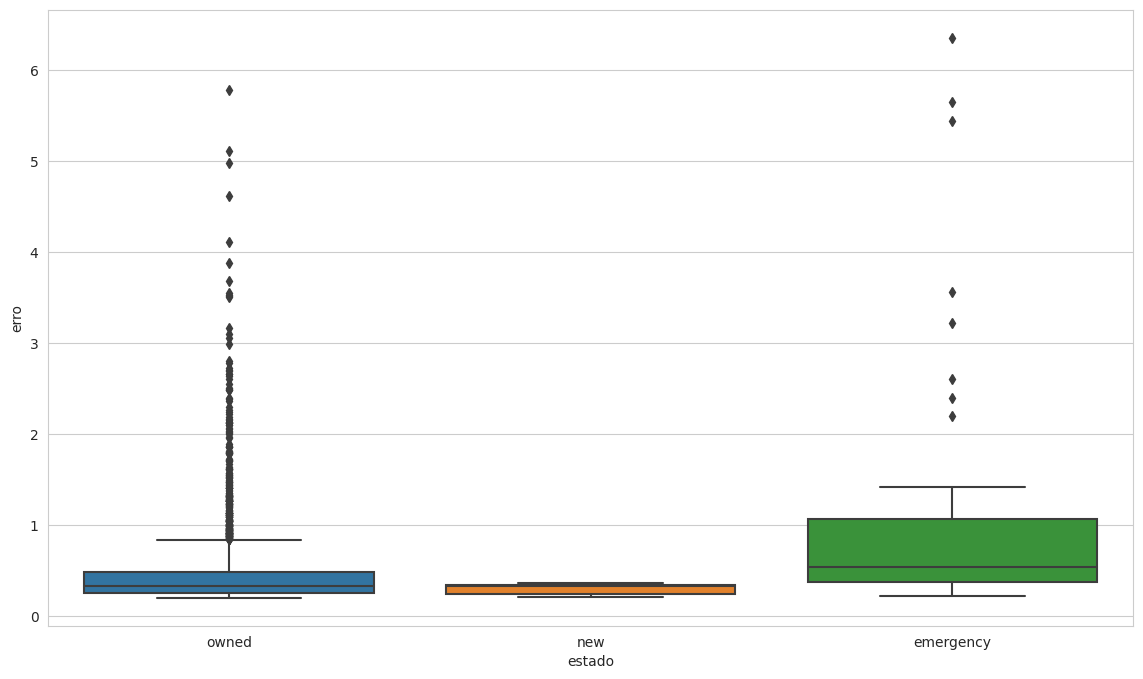

In [462]:
plt.figure(figsize=(14,8))
sns.boxplot(data=erros, x='estado',y='erro');

<b>Conclusão</b>

1. Existem ruídos nos dados e a avaliação de erro, por se tratar de uma média, foi prejudicada.

2. Mais de 80% dos erros maiores do que 20\% se encontram em veículos com até 25 anos de idade.

3. Mais de 80% dos erros maiores que 20\% se encontram em veículos com até 360000 quilômetros rodados.

4. Os erros acima de 20\% se concentram em preços mais baixos.

5. O modelo tem dificuldade em precificar veículos com avarias.

# **Remodelando**

Levantamos alguns pontos acerca da condição do veículo, idade e quilometragem. Vamos agora limpar esses dados e retreinar o nosso modelo

In [463]:
car_train = car_train.query(' estado != "emergency" and idade < 25 and odometro < 360000')
car_test = car_test.query(' estado != "emergency" and idade < 25 and odometro < 360000')

car_train = car_train.reset_index(drop=True)
car_test = car_test.reset_index(drop=True)

Aqui vale lembrar que faremos tudo no dataset de treino e só depois validaremos no dataset de teste.

In [464]:
X_train = car_train.drop(columns=['preco'])
y_train = car_train['preco']

X_test = car_test.drop(columns=['preco'])
y_test = car_test['preco']

In [465]:
cat_pipe = Pipeline([('encoder',TargetEncoder()),
                        ('inputer',SimpleImputer(strategy='most_frequent'))])

num_pipe = Pipeline([('impute',SimpleImputer(strategy='median'))])


preproc = ColumnTransformer([('categoricos',cat_pipe,var_categoricos),
                             ('numericos',num_pipe,var_num)])


model_pipeline = Pipeline([('Preprocessing',preproc)])

modelo.FitModels(X_train,y_train,model_pipeline,log_y=True)

-----linear regression-----
-----Lasso-----
-----Ridge-----
-----Knn-----
-----Random Forest-----
-----lgbm-----
-----xgboost-----
-----Catboost-----


,mae,mape,rmse
linear regression,1659.154791,0.266342,7.446204e+06
Lasso,2805.584716,0.444957,2.203955e+07
Ridge,1659.323833,0.266331,7.448690e+06
Knn,3694.097685,0.725074,3.302600e+07
Random Forest,1258.490190,0.207296,4.531750e+06
lgbm,1224.174125,0.198981,4.260455e+06
xgboost,1202.410207,0.197209,4.093004e+06
Catboost,1157.779804,0.190726,3.816934e+06


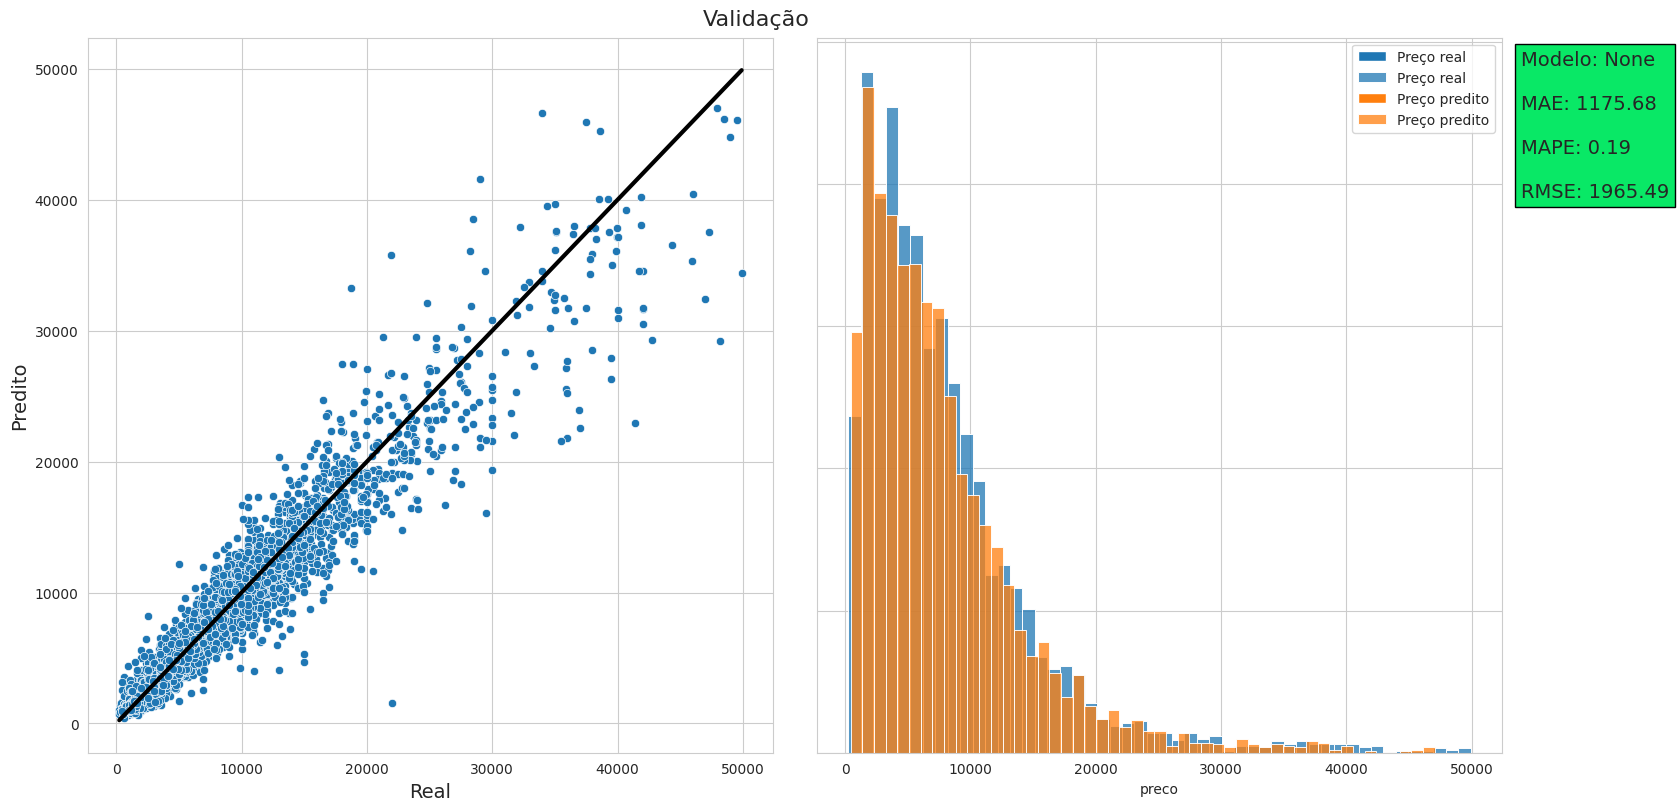

In [466]:
predito , real, avaliacao = modelo.FitoneModel(X = X_train,y = np.log(y_train),pipe = model_pipeline,nome = 'Catboost')

predito = np.exp(predito)

real = np.exp(real)

avaliacao['real'] = real
avaliacao['predito'] = predito
avaliacao['erro'] = np.abs(avaliacao['real'] - avaliacao['predito'])/avaliacao['real']

validacao(real,predito)

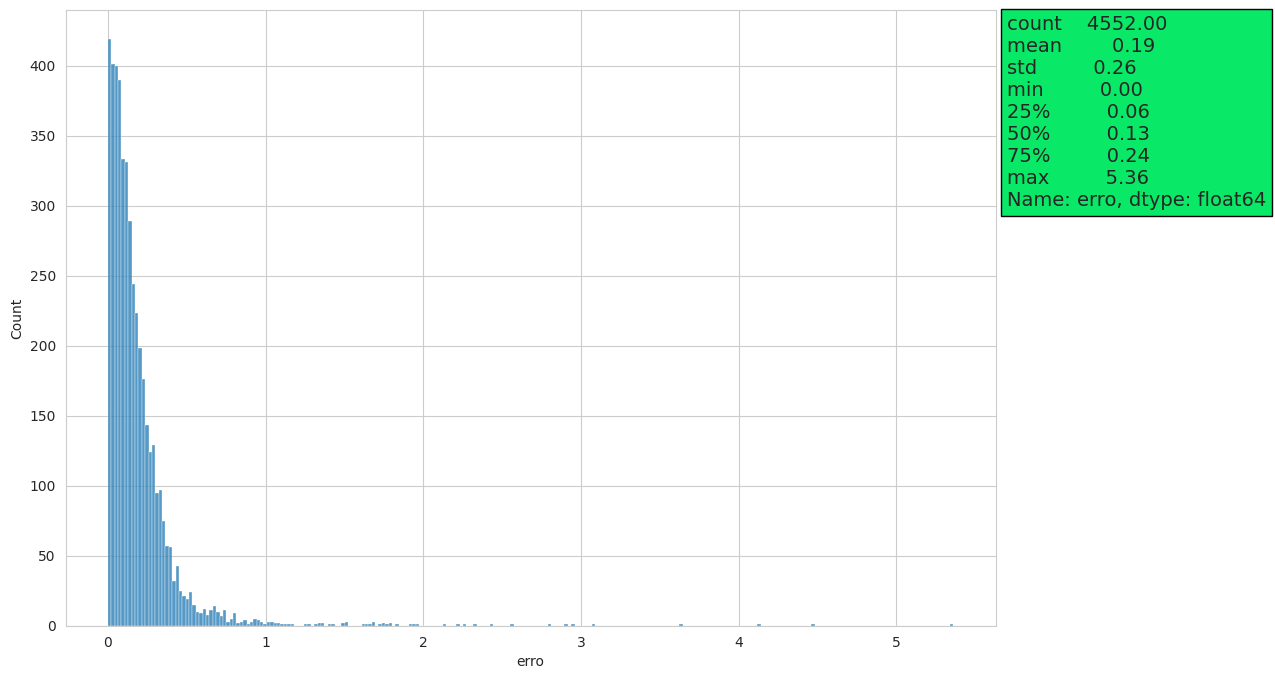

In [467]:
plt.figure(figsize=(12,8))
sns.histplot(data=avaliacao,x='erro')

texto = f"{round(avaliacao['erro'].describe(),2)}"
plt.text(5.7,300,texto,size=14,bbox=dict(boxstyle='square',ec= (0,0,0), fc= (9/255, 232/255, 102/255)));

# **Validando o novo modelo**

In [468]:
model_pipeline.steps.pop()
model_pipeline.steps.append(('modelo',modelo.models['Catboost']))
reg = model_pipeline

In [469]:
reg.fit(X_train,np.log(y_train))

predito = np.exp(reg.predict(X_test))


avaliacao = X_test.copy()

avaliacao['real'] = y_test.copy()
avaliacao['predito'] = predito
avaliacao['erro'] = np.abs(avaliacao['real'] - avaliacao['predito'])/avaliacao['real']

Na tabela a seguir podemos notar a diferença entre a validação anterior com todo o dataset e a nova validação depois da limpeza que fizemos. 

Nessa nova validação conseguimos diminuir nosso erro percentual médio de 36% para 18,8% e alcançamos a meta de ter um erro percentual médio de no máximo 20\%. Além da média observamos também os quartis, onde 75\% dos erros são menores do que 22,7\%.

Outro ponto que devemos notar é a comparação das métricas da nova validação com relação as métricas obtidas no treinamento. As médias, quartis e de um modo geral as estatísticas estão muito similares, e isso indica que o nosso treinamento e validação ocorreram da forma desejada.

In [470]:
pd.concat([avaliacao_base['erro'].describe().to_frame(name ='Validação antiga'),avaliacao['erro'].describe().to_frame(name ='Validação nova')],axis=1)

,Validação antiga,Validação nova
count,7699.000000,5724.000000
mean,0.362636,0.188409
std,8.379750,0.272152
min,0.000017,0.000010
25%,0.065631,0.059532
50%,0.142995,0.126693
75%,0.266340,0.227237
max,589.541875,6.117439


Abaixo estão listados alguns quantis além dos expostos pelo método describe.

In [471]:
avaliacao['erro'].quantile([0.8,0.9,0.92,0.95, 0.97, 0.98 ,0.99]).to_frame()

,erro
0.80,0.260223
0.90,0.374309
0.92,0.414884
0.95,0.513942
0.97,0.659983
0.98,0.824796
0.99,1.258034


E por fim o gráfico exibindo os valores preditos versus os valores reais.

<AxesSubplot: xlabel='Real', ylabel='Predito'>

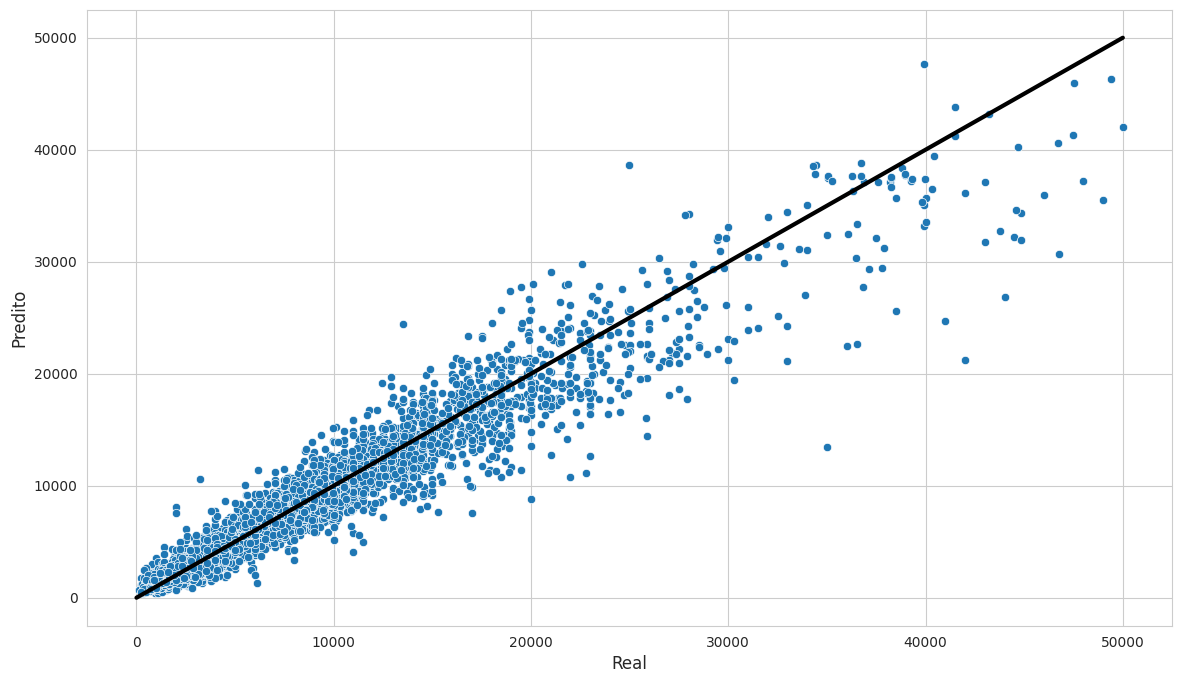

In [472]:
plt.figure(figsize=(14,8))
plt.ylabel('Predito',size=12)
plt.xlabel('Real',size=12)
sns.scatterplot(data=avaliacao, x='real',y='predito')
sns.lineplot(x=[0,50000],y=[0,50000],linewidth=3,c='black')

### **Considerações com relação aos erros**

Vimos nas analises anteriores que os erros se acumularam nos veículos cujo preço é menor e isso não necessariamente é problema do nosso modelo mas sim na métrica utilizada. Estamos predizendo preços em varias ordens de grandezas diferentes e demandar que o erro percentual médio esteja abaixo de 20\% para todas essas escalas é injusto. Vamos discorrer sobre isso nas próximas células.

Consideremos 3 preços em 3 escalas diferentes: 500, 5000, 50000.

respectivamente, 20\% de cada um desses 3 preços é:

1. 20\% de 500 = 100

2. 20\% de 5000 = 1000

3. 20\% de 50000 = 10000

E aqui vemos um dos problemas dessa métrica. 

* Para 500 o modelo só tem liberdade para errar em 100 unidades, isso é, se ele predizer valores acima de 600 ou abaixo de 400 o erro já será maior do que 20\%. 

 * Em contrapartida, para 5000 o modelo tem uma liberdade de erro maior, podendo errar em até mil unidades.

 * Para 50000 essa faixa é ainda maior, podendo errar até 10mil unidades e assim por diante. 

E devido a essa característica que os nosso erros podem estar passando dos 20\% estabelecidos para os veículos que mais baratos. 

Para contornar esse problema devemos visualizar outras métricas.

# **Interpretando o modelo**

Já obtivemos um resultado excelente na validação, agora para finalizar com chave de ouro desejamos entender quais features o modelo considera mais importantes. No gráfico abaixo podemos observar as features mais relevantes para o nosso modelo Catboost, sendo a idade a variável mais importante considerada por ele.


**Observação:** 
* A feature que criamos (qt_combustivel) não foi nada relevante para o modelo.

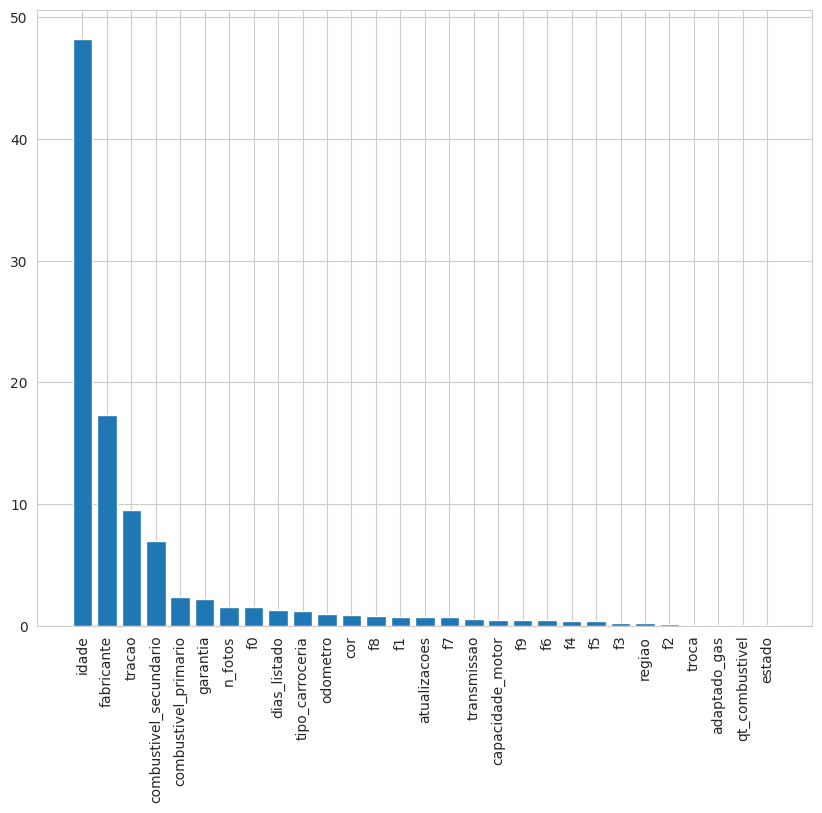

In [473]:
importancias = pd.DataFrame({'importancia': reg.steps[-1][1].get_feature_importance(), 
              'feature': X_test.columns}).sort_values(by=['importancia'], 
                                                           ascending=False)
plt.figure(figsize=(10,8));
plt.xticks(rotation=90);
plt.bar(x=importancias['feature'],height=importancias['importancia']);                                                        

# **Conclusão** 

Nessa modelagem apresentamos uma classe desenvolvida para nos auxiliar no treinamento e validação de diversos modelos de machine learning ao mesmo tempo, além disso, apresentamos passo a passo como as transformações em nossos dados foi alterando as métricas de avaliação propostas. Após uma série de transformações decidimos validar nosso modelo e analisar os resultados obtidos afim de entender onde nosso modelo estava pecando nas predições, e dessa forma fomos capazes de levantar questões e propor novos tratamentos que se mostraram eficazes para obtermos modelos cada vez melhores. 

 No fim, o modelo CatboostRegressor apresentou um erro percentual médio correspondente a 18,8% e as variáveis mais importantes de acordo com esse modelo são, respectivamente, a idade, o fabricante, a tração do veiculo, os combustíveis desse veículo e assim por diante. Observamos que ainda há ruídos nos dados e esses devem ser tratados em novas abordagens.

# **Considerações finais**

Nosso próximo passo seria apresentar os resultados para um superior ou até mesmo para a própria ABC Automóveis. Devemos enfatizar que obtivemos vários modelos com um erro aceitável mas que decidimos focar no Catboost devido esse ter sido nosso melhor modelo, entretanto, existem outros mais simples como o RandomForest. Devemos enfatizar as condições que treinamos o modelo, como selecionar veículos com menos de 25 anos, menos de 360mil quilômetros rodados e entender se a ABC Automóveis está de acordo com essas questões.

Por fim, devemos propor um teste em produção em pequena escala acompanhado de um especialista para assim podermos validar nosso modelo em produção e obter mais dados para futuras melhorias na solução.